In [5]:
import numpy as np
import matplotlib.pyplot as plt

image_file = '../data/raw/pannuke/Fold 1/images/fold1/images.npy'
mask_file = '../data/raw/pannuke/Fold 1/masks/fold1/masks.npy'

images = np.load(image_file)
masks = np.load(mask_file)

In [6]:
types_path = '../data/raw/pannuke/Fold 1/images/fold1/types.npy' 
types = np.load(types_path)

print(f"Types shape: {types.shape}")
print(f"Unique types: {np.unique(types)}")

Types shape: (2656,)
Unique types: ['Adrenal_gland' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon'
 'Esophagus' 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'Ovarian' 'Pancreatic'
 'Prostate' 'Skin' 'Stomach' 'Testis' 'Thyroid' 'Uterus']


In [7]:
single_masks = masks[:, :, :, -1]
single_masks = np.expand_dims(single_masks, axis=-1)
single_masks.shape

(2656, 256, 256, 1)

In [3]:
#np.save('single_mask.npy', single_masks)

In [8]:
types_file = '../data/raw/pannuke/Fold 1/images/fold1/types.npy'
types = np.load(types_file)
colon_indices = np.where(np.logical_or(types == 'Colon', types == 'Stomach', types == 'Esophagus'))[0]

# Convert to list if needed
colon_indices_list = colon_indices.tolist()

single_masks = single_masks[colon_indices_list]

In [9]:
print(len(colon_indices_list))

528


In [29]:
import numpy as np

# Filter out masks where all values are 1
non_all_ones_indices = [i for i, mask in enumerate(single_masks) if not (np.all(mask == 1) or np.all(mask == 0))]

# Filter the images and masks using these indices
filtered_images = images[non_all_ones_indices]
filtered_masks = single_masks[non_all_ones_indices]

print(f"Filtere number of images: {len(filtered_images)}")
print(f"# of masks after filtering: {len(filtered_masks)}")

Filtere number of images: 485
# of masks after filtering: 485


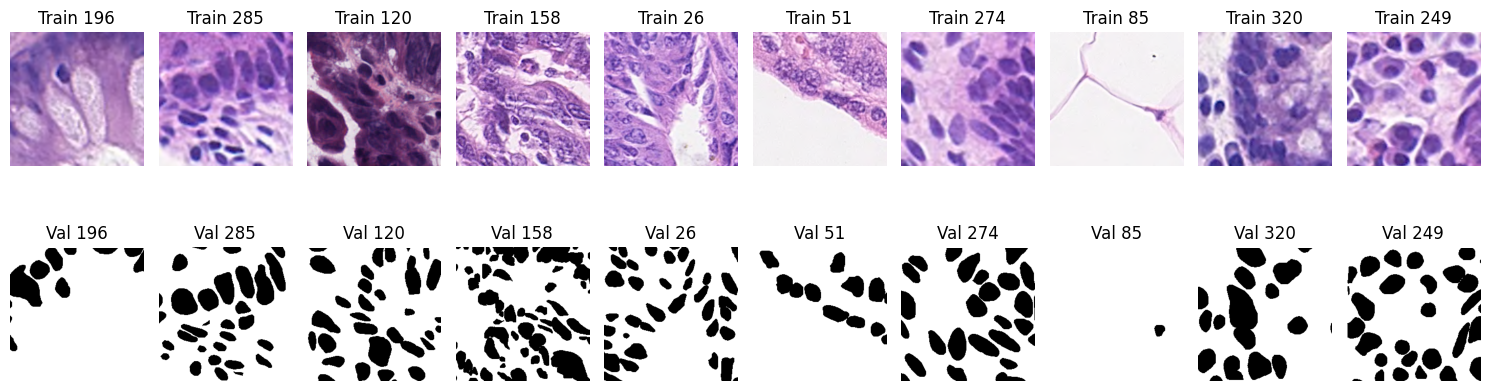

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(X_train, Y_train, num_samples=10):
    # Generate random indices
    random_indices = np.random.choice(len(X_train), num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    # Plot random samples from X_train
    for i, idx in enumerate(random_indices):
        ax = axes[0, i]
        ax.imshow(X_train[idx].astype(int), cmap='gray')  # Assuming grayscale images, adjust cmap for RGB
        ax.set_title(f"Train {idx}")
        ax.axis('off')

    # Plot random samples from Y_train
    for i, idx in enumerate(random_indices):
        ax = axes[1, i]
        ax.imshow(Y_train[idx], cmap='gray')  # Assuming grayscale images, adjust cmap for RGB
        ax.set_title(f"Val {idx}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_random_samples(filtered_images, filtered_masks)


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def rgb_to_od(img):
    img = img.astype(np.float32)
    img[img == 0] = 1  # Avoid division by zero
    return -np.log(img / 255)

def normalize_stains(image, target_means, target_stds):
    # Convert RGB to Optical Density (OD)
    img_od = rgb_to_od(image)

    # Reshape for PCA
    reshaped_od = img_od.reshape((-1, 3))

    # Perform PCA to find the stain matrix
    pca = PCA(n_components=2)
    pca.fit(reshaped_od)
    stain_matrix = pca.components_.T

    # Calculate stains
    stains = np.dot(reshaped_od, np.linalg.pinv(stain_matrix).T)
    stains = stains.reshape(img_od.shape[0], img_od.shape[1], -1)

    # Normalize stains
    stains_normalized = (stains - np.mean(stains, axis=(0, 1))) / np.std(stains, axis=(0, 1))
    stains_normalized = stains_normalized * target_stds + target_means

    # Convert back to OD space
    od_normalized = np.dot(stains_normalized.reshape((-1, 2)), stain_matrix.T)
    od_normalized = od_normalized.reshape(image.shape)

    # Reconstruct image from OD
    img_reconstructed = np.exp(-od_normalized)
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    img_reconstructed = (img_reconstructed * 255).astype(np.uint8)

    return img_reconstructed

images = filtered_images
images_macenko = []

target_means = np.array([0.5, 0.5])
target_stds = np.array([0.2, 0.2])

for i, image in enumerate(images):
    img_reconstructed = normalize_stains(image, target_means, target_stds)
    images_macenko.append(img_reconstructed)


In [35]:
# Assuming images_macenko is a list of images
images_macenko = [np.array(img) for img in images_macenko]  # Ensure all items are numpy arrays

# Convert the list of images to a NumPy array
images_macenko_array = np.array(images_macenko)

# Alternatively, if images are of the same shape and you want to stack them along a new dimension
images_macenko_array = np.stack(images_macenko, axis=0)

# Print the shape of the resulting NumPy array
print(f"Shape of images_macenko_array: {images_macenko_array.shape}")

Shape of images_macenko_array: (485, 256, 256, 3)


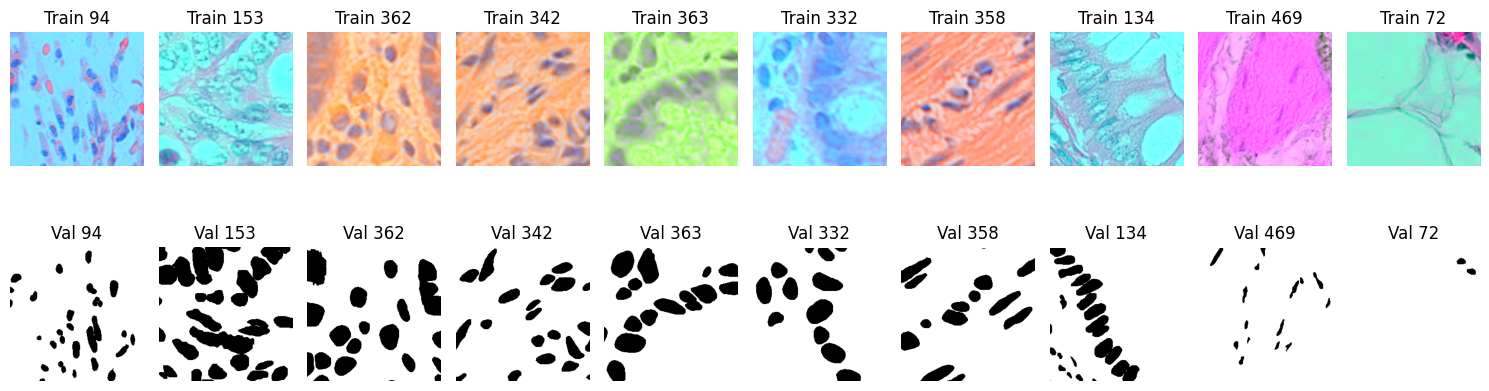

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(X_train, Y_train, num_samples=10):
    # Generate random indices
    random_indices = np.random.choice(len(X_train), num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    # Plot random samples from X_train
    for i, idx in enumerate(random_indices):
        ax = axes[0, i]
        ax.imshow(X_train[idx].astype(int), cmap='gray')  # Assuming grayscale images, adjust cmap for RGB
        ax.set_title(f"Train {idx}")
        ax.axis('off')

    # Plot random samples from Y_train
    for i, idx in enumerate(random_indices):
        ax = axes[1, i]
        ax.imshow(Y_train[idx], cmap='gray')  # Assuming grayscale images, adjust cmap for RGB
        ax.set_title(f"Val {idx}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_random_samples(images_macenko_array, filtered_masks)


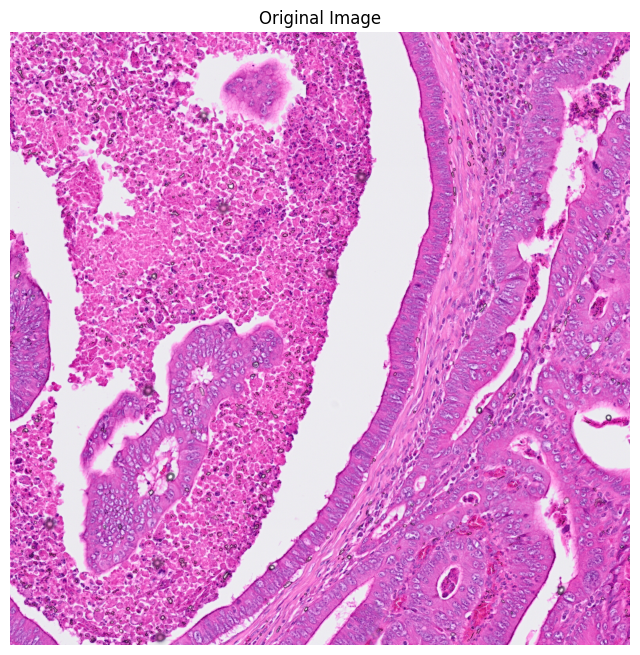

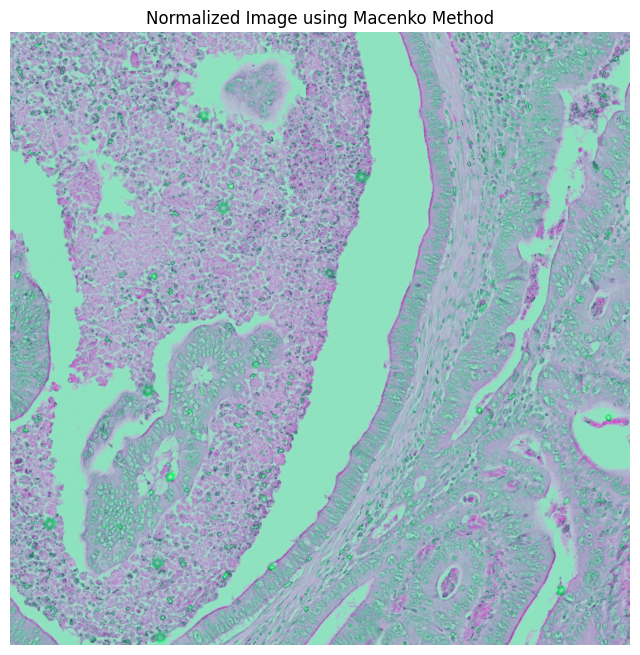

In [2]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import read_image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Macenko Stain Normalization Functions
def rgb_to_od(img):
    img = img.astype(np.float32)
    img[img == 0] = 1  # Avoid division by zero
    return -np.log(img / 255)

def normalize_stains(image, target_means, target_stds):
    # Convert RGB to Optical Density (OD)
    img_od = rgb_to_od(image)

    # Reshape for PCA
    reshaped_od = img_od.reshape((-1, 3))

    # Perform PCA to find the stain matrix
    pca = PCA(n_components=2)
    pca.fit(reshaped_od)
    stain_matrix = pca.components_.T

    # Calculate stains
    stains = np.dot(reshaped_od, np.linalg.pinv(stain_matrix).T)
    stains = stains.reshape(img_od.shape[0], img_od.shape[1], -1)

    # Normalize stains
    stains_normalized = (stains - np.mean(stains, axis=(0, 1))) / np.std(stains, axis=(0, 1))
    stains_normalized = stains_normalized * target_stds + target_means

    # Convert back to OD space
    od_normalized = np.dot(stains_normalized.reshape((-1, 2)), stain_matrix.T)
    od_normalized = od_normalized.reshape(image.shape)

    # Reconstruct image from OD
    img_reconstructed = np.exp(-od_normalized)
    img_reconstructed = np.clip(img_reconstructed, 0, 1)
    img_reconstructed = (img_reconstructed * 255).astype(np.uint8)

    return img_reconstructed

def plot_image(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off axis
    plt.show()

# Example usage
dir_base = '/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/processed/'
filename = 'p5_cropped_image_overlap_comparison.btf'
img = read_image(dir_base + filename)

# Define target means and stds
target_means = np.array([0.5, 0.5])
target_stds = np.array([0.2, 0.2])

# Normalize the image using the Macenko method
img_macenko = normalize_stains(img, target_means, target_stds)

# Plot original and normalized images
plot_image(img, "Original Image")
plot_image(img_macenko, "Normalized Image using Macenko Method")


In [47]:
from sklearn.model_selection import train_test_split
images_macenko_array = images_macenko_array / 255.0
X_train, X_val, Y_train, Y_val = train_test_split(images_macenko_array[:400], filtered_masks[:400], test_size=0.2, random_state=40)

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)

    return model


In [50]:
model = unet_model()

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_7[0][0], 

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(X_train, Y_train, batch_size=16, epochs=5, validation_data=(X_val, Y_val))

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 615s 29s/step - accuracy: 0.8060 - loss: 0.5148 - val_accuracy: 0.8022 - val_loss: 0.4648
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 683s 35s/step - accuracy: 0.8074 - loss: 0.4469 - val_accuracy: 0.8070 - val_loss: 0.4565
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 587s 29s/step - accuracy: 0.8158 - loss: 0.4362 - val_accuracy: 0.8079 - val_loss: 0.4453
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 549s 28s/step - accuracy: 0.8373 - loss: 0.3925 - val_accuracy: 0.7852 - val_loss: 0.5028
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 506s 25s/step - accuracy: 0.8280 - loss: 0.4123 - val_accuracy: 0.8369 - val_loss: 0.4054


In [53]:
model.save('../data/processed/pannuke/colon_and_stomach_5e_M_GG_01.h5')

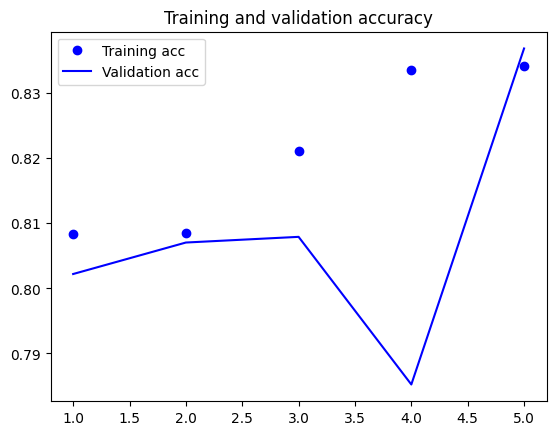

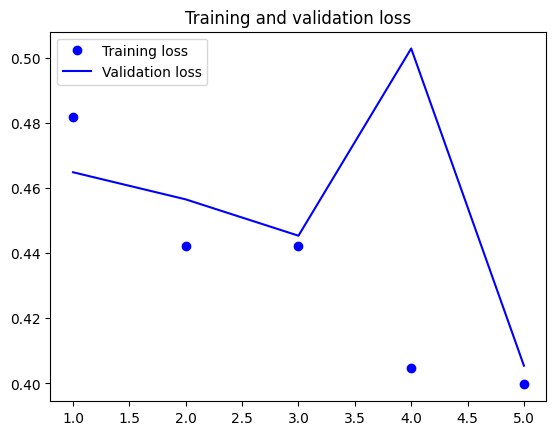

In [54]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


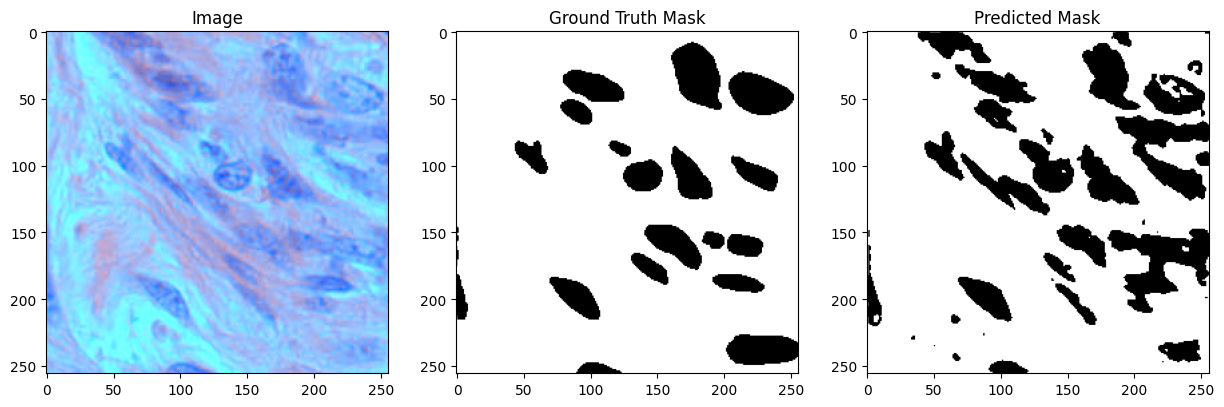

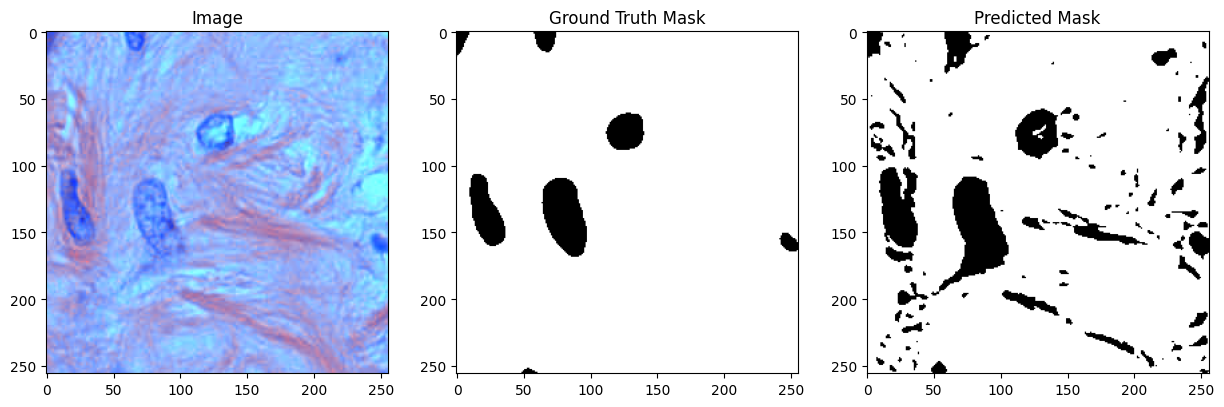

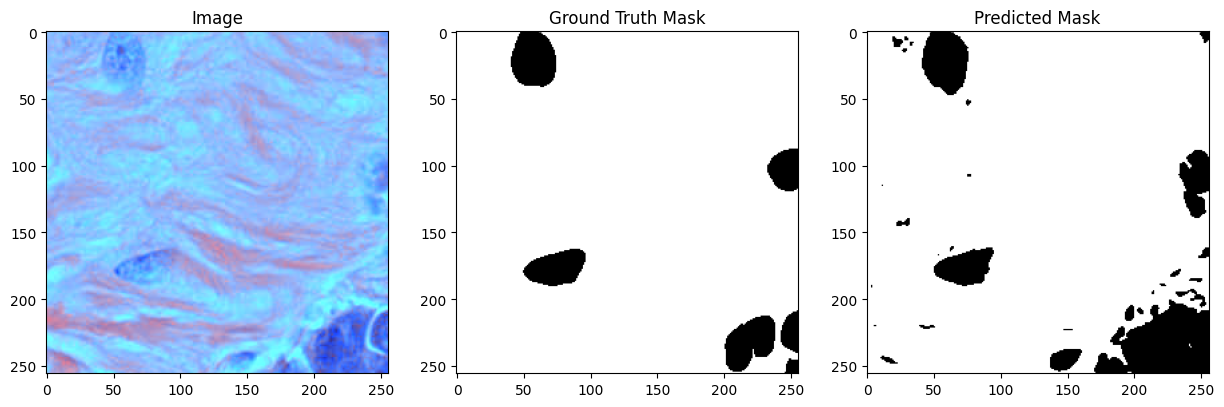

In [56]:
import numpy as np
import matplotlib.pyplot as plt

X_test = images_macenko_array[400:404]
Y_test = filtered_masks[400:404]

Y_pred = model.predict(X_test)

# Reshape predictions to match ground truth
Y_pred_thresholded = (Y_pred > 0.5).astype(np.uint8)

# Remove the last channel dimension
Y_pred_thresholded = np.squeeze(Y_pred_thresholded, axis=-1)


def plot_sample(image, true_mask, pred_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[1].imshow(true_mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    plt.show()

for i in range(3):
    plot_sample(X_test[i], Y_test[i], Y_pred_thresholded[i])


In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

def extract_patches(image, patch_size=(256, 256), overlap=0.5):
    patches = []
    stride = int(patch_size[0] * (1 - overlap))
    for y in range(0, image.shape[0] - patch_size[0] + 1, stride):
        for x in range(0, image.shape[1] - patch_size[1] + 1, stride):
            patch = image[y:y + patch_size[0], x:x + patch_size[1]]
            patches.append((patch, (x, y)))
    return patches

def plot_patch_vs_mask(original_patch, predicted_mask_patch):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_patch)
    axes[0].set_title('Original Patch')
    axes[0].axis('off')

    axes[1].imshow(predicted_mask_patch.squeeze(), cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.show()

large_image = img_macenko / 255.0

patch_size = (256, 256)
overlap = 0.5
patches = extract_patches(large_image, patch_size=patch_size, overlap=overlap)

model = tf.keras.models.load_model('/Users/lollijagladiseva/Desktop/cellseg_visium_hd/data/processed/pannuke/colon_and_stomach_5e_M_GG_01.h5')
predictions = []
predictions_thresholded = []

for patch, position in patches:
    patch = patch[np.newaxis, ...]
    pred = model.predict(patch)
    predictions.append((pred.squeeze(), position))
    pred = (pred > 0.5).astype(np.uint8)  # threshold prediction
    predictions_thresholded.append((pred.squeeze(), position))  # remove batch dimension


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [27]:
predictions

[(array([[0.6258222 , 0.60506123, 0.59864944, ..., 0.7353454 , 0.70837045,
          0.62933636],
         [0.67998433, 0.6169395 , 0.5812983 , ..., 0.72337264, 0.7234747 ,
          0.6837934 ],
         [0.7559905 , 0.6877284 , 0.63983744, ..., 0.72869986, 0.73563856,
          0.7109043 ],
         ...,
         [0.87224346, 0.87794405, 0.8785649 , ..., 0.7317549 , 0.7257755 ,
          0.6837752 ],
         [0.8427766 , 0.8663505 , 0.8789009 , ..., 0.78744596, 0.7580869 ,
          0.68871087],
         [0.75647163, 0.81830204, 0.8523429 , ..., 0.80089796, 0.76493984,
          0.6924865 ]], dtype=float32),
  (0, 0)),
 (array([[0.68783855, 0.71194494, 0.738977  , ..., 0.8167482 , 0.7942684 ,
          0.7037598 ],
         [0.72468543, 0.70518005, 0.71045953, ..., 0.83194906, 0.8309146 ,
          0.7757364 ],
         [0.7446467 , 0.6899927 , 0.6758065 , ..., 0.83854187, 0.8393364 ,
          0.7961921 ],
         ...,
         [0.8269284 , 0.80709124, 0.7849373 , ..., 0.8366542 ,

In [28]:
predictions_thresholded
pred_min = np.min(predictions_thresholded[0][0])
pred_max = np.max(predictions_thresholded[0][0])
print(pred_max)
print(pred_min)
predictions_thresholded

1
0


[(array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (0, 0)),
 (array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (128, 0)),
 (array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 1, 1],
         [1, 1, 1, ..., 0, 0, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (256, 0)),
 (array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
  (384, 0)),
 (array([[1, 1, 1,

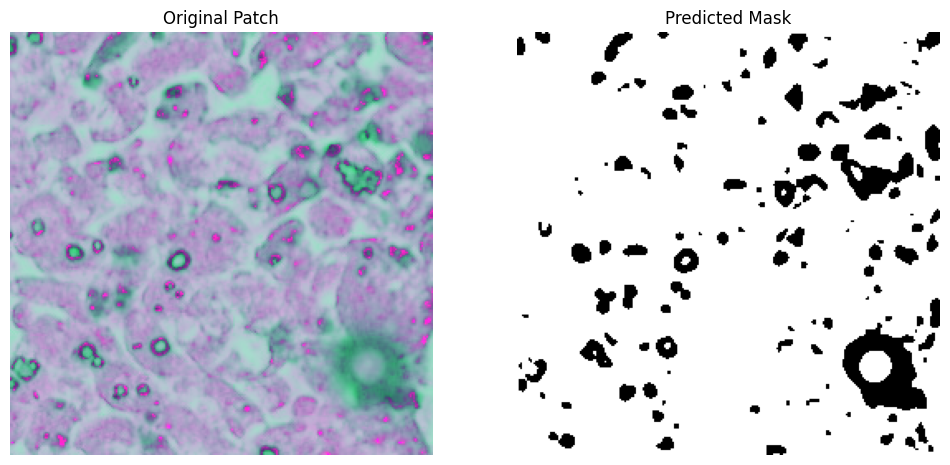

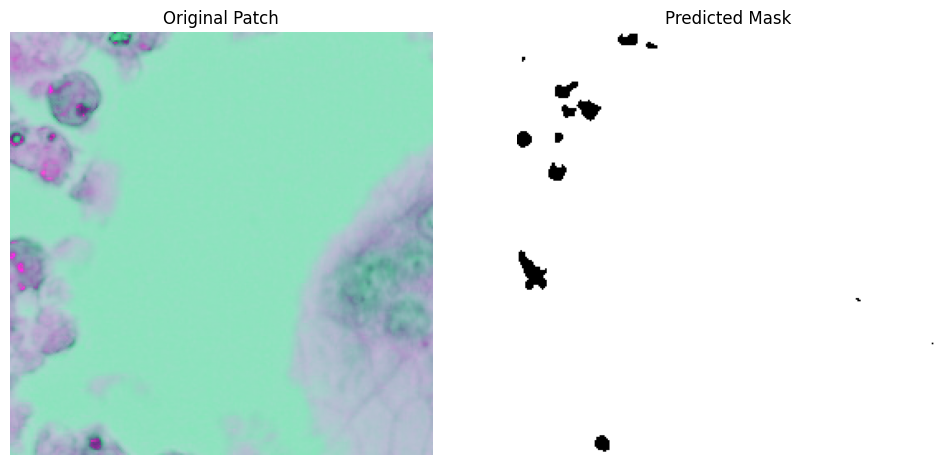

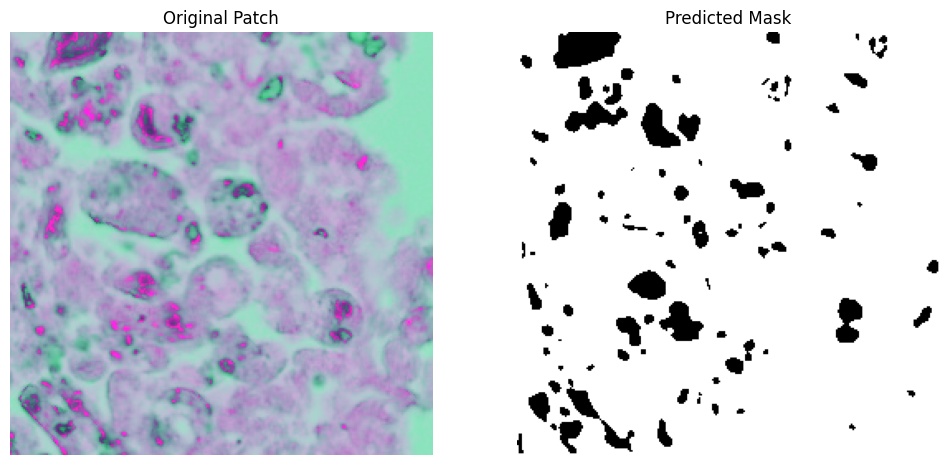

In [29]:
# 3 random patches
random_indices = random.sample(range(len(patches)), 3)
for i in random_indices:
    patch, _ = patches[i]
    pred, _ = predictions_thresholded[i]
    
    plot_patch_vs_mask(patch, pred)